In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from copy import deepcopy

from helpers.plotting import plot_patient
%load_ext autoreload
%autoreload 2
np.random.seed(0)
random.seed(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [9]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

### Load the data

In [10]:
import pickle

with open('cycles.pkl', 'rb') as f:
    cycles_tfp = pickle.load(f)

all_cycles = cycles_tfp

In [11]:
with open('best_params_all_scans.pkl', 'rb') as f:
    best_params_dict = pickle.load(f)
    

In [12]:
from sklearn.model_selection import train_test_split
from experiment_framework import data_prep_for_RF
from sklearn.ensemble import RandomForestRegressor

train_patients, test_patients = train_test_split(all_cycles, test_size=0.3, random_state=0)

results_dict = {}
train_test_X_y, train_patients, test_patients = data_prep_for_RF(train_patients=train_patients,
                                                                 test_patients=test_patients)




100%|██████████| 671/671 [00:06<00:00, 98.15it/s] 


### Train RF models

In [13]:
models_dict = {}
for bin in train_test_X_y.keys():
    print(bin)
    models_dict[bin] = RandomForestRegressor(n_estimators=round(best_params_dict[bin]['n_estimators']),
                                             max_depth=round(best_params_dict[bin]['max_depth']),
                                             min_samples_leaf=best_params_dict[bin]['min_samples_leaf'],
                                             min_samples_split=best_params_dict[bin]['min_samples_split'],
                                             random_state=42,
                                             n_jobs=-1)
    # replace nan with -1 in 'weight' column
    train_test_X_y[bin]['X_train']['weight'] = train_test_X_y[bin]['X_train']['weight'].fillna(-1)
    

    models_dict[bin].fit(train_test_X_y[bin]['X_train'], train_test_X_y[bin]['y_train'])

models_dict['bins'] = train_test_X_y.keys()

5-8
8-11
11-14
14-17
17-20
20-23
23-26


### Train histostep model

In [14]:
from modelling.histostep_model_v2 import HistostepModel2


histomodel = HistostepModel2()
histomodel.train(train_patients, gaussian_filter=True)


Generating stats for predictors
Predictor: age


100%|██████████| 437/437 [00:00<00:00, 24912.82it/s]


Predictor: weight


100%|██████████| 147/147 [00:00<00:00, 19500.37it/s]


Predictor: afc


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Predictor: init_dose


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Predictor: protocol


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


Predictor: overall


100%|██████████| 1563/1563 [00:00<00:00, 23348.91it/s]


Predictor: amh


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


### Predict on test patients

In [16]:
from experiment_framework import drop_scans_in_between

cycles_no_scans_between = deepcopy(test_patients)
cycles_no_scans_between = drop_scans_in_between(cycles_no_scans_between)
simulated_corrected, _ = histomodel.predict(cycles_no_scans_between, add_missing_dates=True, use_bin_act_only=True,
                                            follicle_only=True, bin_only=False)

100%|██████████| 671/671 [00:18<00:00, 36.31it/s]


### Plot a cycle

no
yes


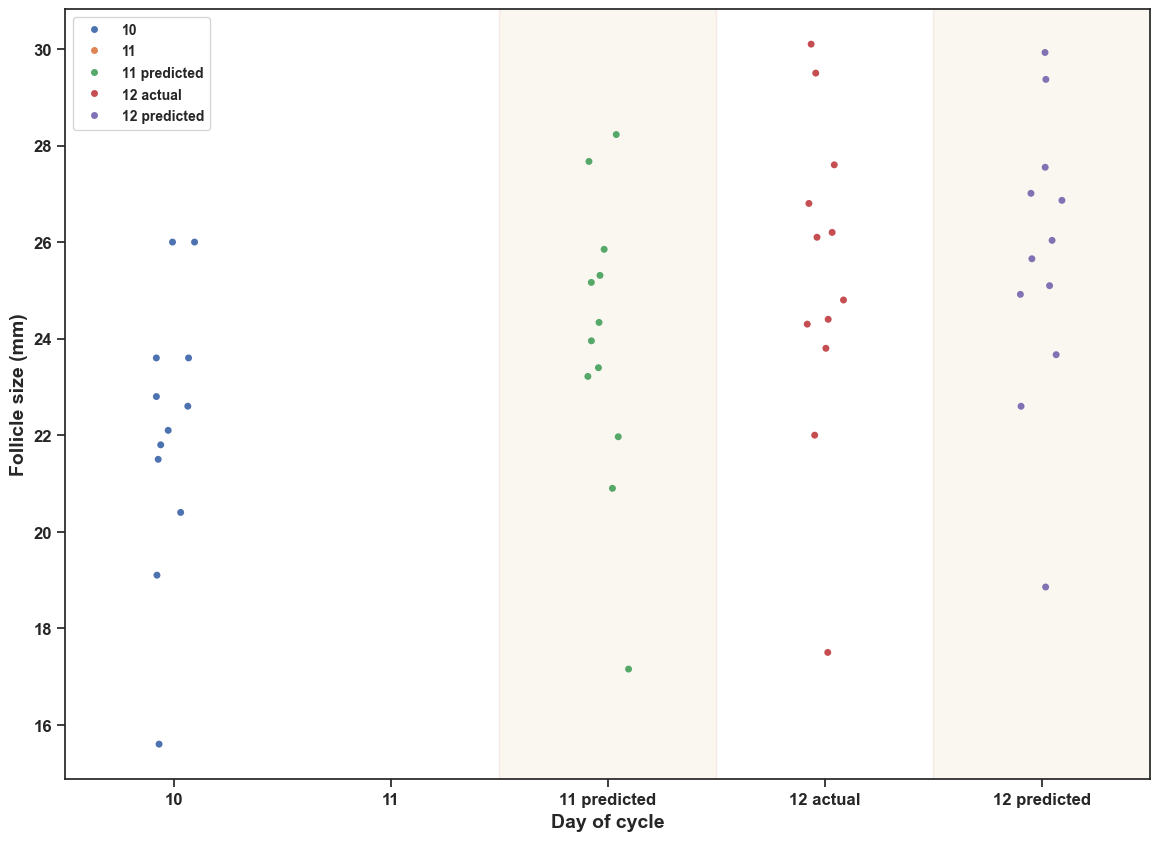

In [18]:
from helpers.plotting import plot_patient
df_ = plot_patient(simulated_corrected[0], plot_until_last_act=True)